# Lecture 3-4: Intensity Transformations

## 0.- Initialize filesystem and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pydicom

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom
from IPython.display import Image, display

## 1.- Pixel Transformation

The **spatial domain** of an image refers to the representation of the image as a **collection of pixels** arranged in a **2D grid**.

Image enhancement based on **point processing techniques** (**intensity transformations**) transform pixel values in the input image based only on their **individual intensities** by applying a transformation.

The resulting output image consists of an **improved version of the original image**, with better characteristics for a specific task.

The **new value** for a specific pixel will depend on the **current intensity value** and the **function** applied, $T(x)$, and not on the values of the surrounding pixels (as it happens in spatial filtering techniques).

For **grayscale images**, the transformation range is $[0, L−1]$, where $L = 2^k$ and $k$ is the number of bits in an image.

The most common **bit-depths** are **8-bit** images, in which the range of intensity values is [0, 255], and **16-bit** image, with a range of [0, 65535], but the pixel transformation techniques can be applied to images of any bit depth.

**Point processing techniques** can be classified into **three categories**:

* **Mathematical mapping functions**: transform pixel values by applying mathematical functions to the input value.

* **Histogram-based techniques**: rely on the distribution of pixel intensities across the entire image, as represented by a histogram, to redistribute pixel intensities to achieve a more uniform or desired distribution.

* **Bit-plane slicing**: involves breaking down the pixel values into their binary components and analyzing or modifying specific bit planes to emphasize different levels of detail.

## 2.- Mathematical Mapping Functions

### 2.1. Negative Transformation (Inverse Image)

**Negative transformation** or **image inverse** is a linear transformation that **inverts the intensity values** of the input image with respect to the maximum bit depth.

The transformation is defined as:

$$I_{\text{new}}(x, y) = T(x, y) = (L - 1) - I(x, y)$$

where:

* $T(x, y)$ is the transformation function for a pixel with coordinates $x$ and $y$,
* $L - 1$ is the maximum intensity value,
* $I(x, y)$ is the intensity of the pixel with the same coordinates in the original image,
*	$I_{\text{new}}(x, y)$ is the transformed intensity of the pixel.

This results in a new image that is the equivalent of a **photographic negative**. This type of processing is used, for example, to enhance white or gray detail embedded in dark regions of an image, especially when the black areas are dominant in size.

Although the visual content is the same in both images, **in some cases it is easier** to analyze some details of an image (tissue, vessels, ...) **in the negative image**.

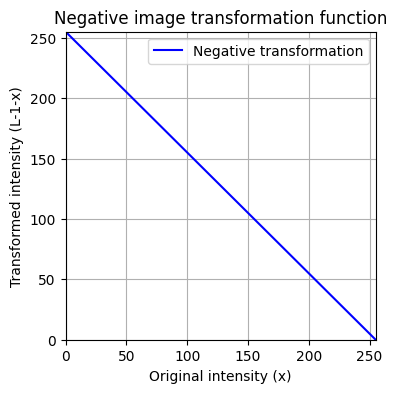

In [ ]:
# Maximum intensity value L for an 8-bit image
L = 256

# Create an array of intensity values from 0 to L-1 (default step = 1)
x = np.arange(0, L)

# Calculate the negative transformation
y = L - 1 - x

# Plot the transformation function
plt.figure(figsize=(4, 4))
plt.plot(x, y, label="Negative transformation", color='blue')
plt.xlabel('Original intensity (x)')
plt.ylabel('Transformed intensity (L-1-x)')
plt.title('Negative image transformation function')
plt.xlim(0, L-1)
plt.ylim(0, L-1)
plt.grid(True)
plt.legend()
plt.show()

The computation of the inverse image can be done in two ways:

* using **arithmetic operations** ($L - 1 - x$): this method uses arrays in NumPy to perform the subtraction, or

* using **bitwise operations**: uses an OpenCV function, `cv2.bitwise_not(image)`, to compute the 1's complement of every bit for every pixel in the image. These type of functions are **optimized for images**, so this method may be slightly faster.

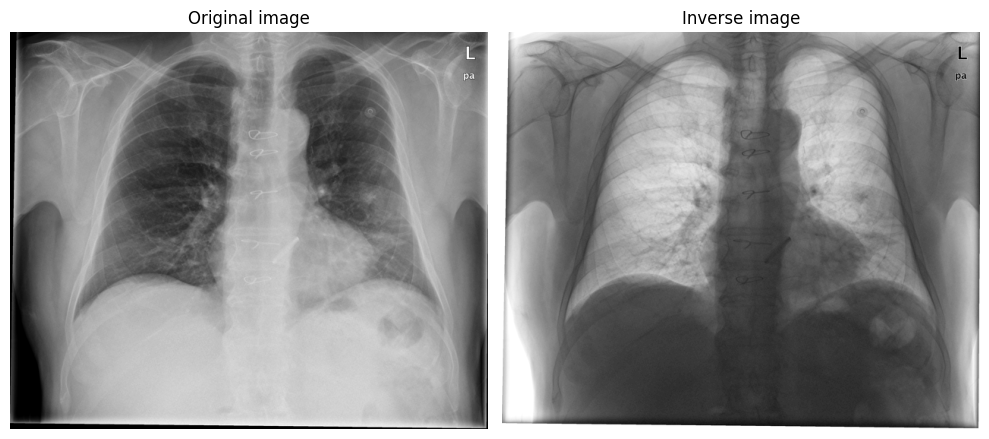

In [ ]:
# Load the image from a file in Google Drive
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Compute the inverse of the image
#inverse_image = 255 - image # 1st method (NumPy)
#
inverse_image = cv2.bitwise_not(image) # 2nd method (OpenCV): using bitwise NOT
                                       # (1's complement) to every bit
                                       # for every byte (pixel) in the image

# Save the inverse image to a file
output_path = '/content/drive/MyDrive/PIM/Images/inverse_image.jpeg'
cv2.imwrite(output_path, inverse_image)

# Create a figure with a single row and two columns
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title("Original image")
plt.axis('off')

# Plot the inverse image
plt.subplot(1, 2, 2)
plt.imshow(inverse_image, cmap='gray', vmin=0, vmax=255)
plt.title("Inverse image")
plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 2.2. Power Law Transformation (Gamma Correction)

Power law transformation **adjusts the brightness** of an image to match the **human perception** of brightness. It is typically used in devices that acquire or display images, such as monitors.

In image processing, it is used to **enhance the quality** of the image by **making it brighter or darker through non-linear mapping** of the original pixel intensities to new pixel intensities.

Gamma correction transformation is given by:

$$I_{\text{new}}(x, y) = T(x, y) = k \cdot I(x, y)^{\gamma}$$

where $k$ and $\gamma$ are positive constants. Usually, $k = 1$.

* If $\gamma = 1$, the mapping is **linear** and the resulting image is the same as the input image (**identity** function).

* If $\gamma < 1$, the transformation function is **above** the identity function, which means that every input value is assigned a **higher** (brighter) value.

  This transformation has the effect of **mapping** a narrow range of low-intensity pixel values from the input image to a wider range of intensities in the output image, and a broad range of high-intensity pixel values to a narrower range of pixels in the output image.
  
  The **percentual increase in brightness** is higher for darker pixel values compared to brighter ones, even though all pixel values will become brighter. The overall effect is that the modified image results **brighter** than the original.

*	If $\gamma > 1$, the opposite occurs: every pixel is assigned a **lower** value (the function is under the identity function), so the output image will be **darker** than the original.

  In this case, the transformation compresses the intensity values in the darker regions, making them darker, and expands the values in the brighter regions, making them brighter.

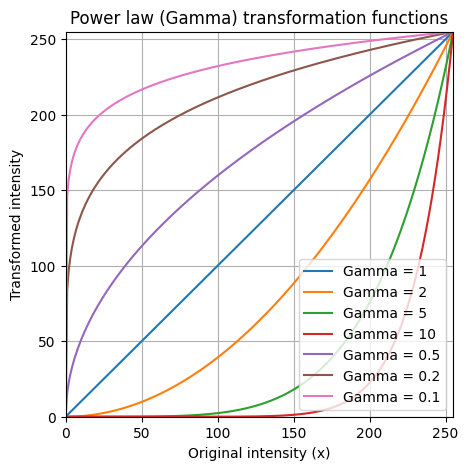

In [ ]:
# Maximum intensity value L for an 8-bit image
L = 256

# Create an array of intensity values from 0 to L-1
x = np.arange(0, L)

# Define the gamma values
gamma_values = [1, 2, 5, 10, 1/2, 1/5, 1/10]

# Plot the power law transformations
plt.figure(figsize=(5, 5))

for gamma in gamma_values:
    y = (x / float(L - 1)) ** gamma * (L - 1)
    plt.plot(x, y, label=f"Gamma = {gamma}")

plt.xlabel('Original intensity (x)')
plt.ylabel('Transformed intensity')
plt.title('Power law (Gamma) transformation functions')
plt.xlim(0, L-1)
plt.ylim(0, L-1)
plt.grid(True)
plt.legend()
plt.show()

For $\gamma > 1$ (and assuming $k = 1$, $\max(I) = 255$, and $\min(I) = 0$), the majority of resulting intensities will be **out of bounds** ($I_\text{new} > 255$), so it is necessary to **normalize** the result relative to the maximum value.

Then, the steps when applying the power law transformation are:

1. normalize the image values: $I_{\text{norm}}(x,y) = \dfrac{I(x,y) - \min(I)}{\max(I) - \min(I)} = \dfrac{I(x,y)}{\max(I)}$

2. apply the power law transformation: $I_{\text{new,norm}} = I_{\text{norm}}(x,y)^{\gamma}$

3. scaled back the image to the original range: $I_{\text{new}}(x,y) = I_{\text{new,norm}}(x,y) \cdot (\max(I) - \min(I)) + \min(I) = I_{\text{new,norm}}(x,y) \cdot \max(I)$

In [ ]:
# Define the image array
image = np.array([0, 63, 127, 191, 255])

# Normalize the image values to the range [0, 1]
normalized_image = image / 255.0

# Apply the power law transformation with gamma. The result is in the range [0, 1]
gamma = 3
corrected_normalized_image = np.power(normalized_image, gamma)

# Scale back to the original range [0, 255]
corrected_image = np.uint8(corrected_normalized_image * 255)

# Alternatively, the three steps are equivalent to:
#corrected_image = np.uint8(np.power(image / 255.0, gamma) * 255)

# Print the arrays
print("Original image:", image)
print("Normalized image:", normalized_image)
print("Corrected normalized image:", corrected_normalized_image)
print("Corrected image:", corrected_image)

Original image: [  0  63 127 191 255]
Normalized image: [0.         0.24705882 0.49803922 0.74901961 1.        ]
Corrected normalized image: [0.         0.01507999 0.12353517 0.42022275 1.        ]
Corrected image: [  0   3  31 107 255]


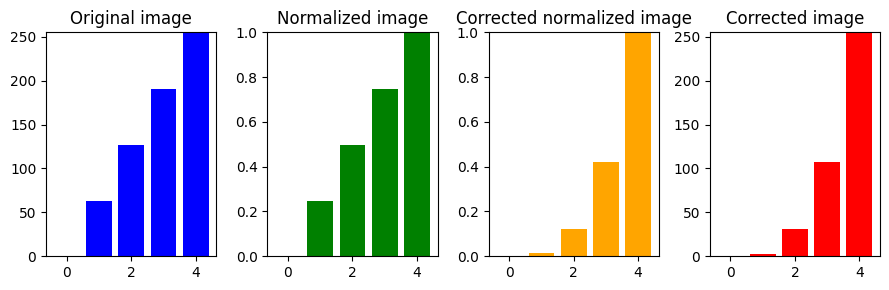

In [ ]:
# Plot the results
plt.figure(figsize=(9, 3))

# Original image
plt.subplot(1, 4, 1)
plt.bar(list(range(len(image))), image, color='blue') # range(...) returns
                                                      # a range object, not a list
plt.title('Original image')
plt.ylim(0, 255)

# Normalized image
plt.subplot(1, 4, 2)
plt.bar(list(range(len(normalized_image))), normalized_image, color='green')
plt.title('Normalized image')
plt.ylim(0, 1)

# Corrected normalized image
plt.subplot(1, 4, 3)
plt.bar(list(range(len(corrected_normalized_image))), corrected_normalized_image, color='orange')
plt.title('Corrected normalized image')
plt.ylim(0, 1)

# Corrected image
plt.subplot(1, 4, 4)
plt.bar(list(range(len(corrected_image))), corrected_image, color='red')
plt.title('Corrected image')
plt.ylim(0, 255)

plt.tight_layout()
plt.show()

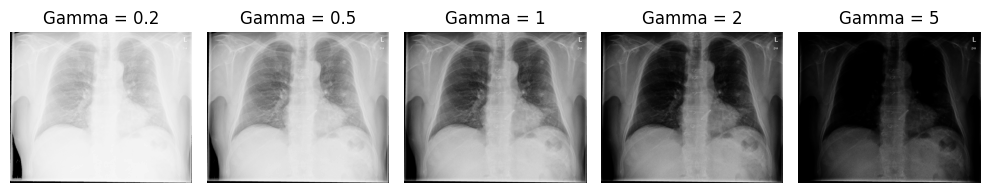

In [ ]:
# Load the image from a file in Google Drive
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define the gamma values
gamma_values = [1/5, 1/2, 1, 2, 5]

# Create a figure with 1 row and 5 columns
plt.figure(figsize=(10, 4))

# Plot each gamma corrected image
for i, gamma in enumerate(gamma_values): # enumerate returns the index and the value
  plt.subplot(1, 5, i + 1)
  # normalize ( / 255.0), apply gamma correction (np.power(...)), and scale back ( * 255)
  corrected_image = np.uint8(np.power(image / 255.0, gamma) * 255)
  plt.imshow(corrected_image, cmap='gray', vmin=0, vmax=255)
  plt.title(f'Gamma = {gamma}')
  plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 2.3. Logarithmic and exponential transformations

**Logarithmic transformation**

Logarithmic transformation maps a narrow range of low-intensity values in the input image to a wider range of output values, **enhancing the visibility of details in the darker regions**. Conversely, it compresses the bright regions to a narrower range. The result is a **britghter image**.

The transformation function can be expressed as:

$$I_{\text{new}}(x,y) = T(x,y) = k \cdot \log(1 + I(x,y))$$

where:

*	$I(x,y)$ is the original intensity of the pixel at position (x,y),
*	$I_{\text{new}}(x,y)$ is the transformed intensity,
*	$k=\dfrac{L-1}{\log(1+I_{\text{max}})}$ is a constant, typically chosen to scale the output image appropriately.

Usually, base 10 and base $e$ are used for logarithms.

The logarithmic transformation can be seen **similar to the gamma correction for $\gamma < 1$**.

The **difference** between these two techniques is that the gamma transformation brightens dark areas **more aggressively** and can be adjusted with the $\gamma$ parameter, while the logarithmic transformation enhances shadows **more gradually**.

The log function can be applied not only to spatial images, but also to **images derived from spatial images** (e.g, the result of a 2D Fourier Transform) to enhance the visibility of the transformed image.



**Exponential transformation**

The exponential transformation can be considered the **inverse** of the logarithmic transformation, and is used to **expand the brighter regions and compress the darker regions** of an image (similar to power law transformation for $\gamma > 1$).

The transformation function can be expressed as:

$$I_{\text{new}}(x, y) = T(x, y) = k \cdot (e^{\alpha \cdot I(x, y)} - 1)$$

where:

*	$I(x, y)$ is the original intensity of the pixel at position $(x,y)$,
*	$I_{\text{new}}(x, y)$ is the transformed intensity,
*	$k$ is a constant used to scale the output image,
* $\alpha$ controls the degree of enhancement,
*	$e$ is the base of the natural logarithm.

Including normalization and scaling back, the expression results:

$$I_{\text{new}}(x, y) = T(x, y) = e^{\frac{I(x, y)}{L - 1}\cdot \log(L)} - 1$$

This transformation maps a narrow range of high-intensity values in the input image to a wider range of output values, **making details in the brighter regions more prominent**.




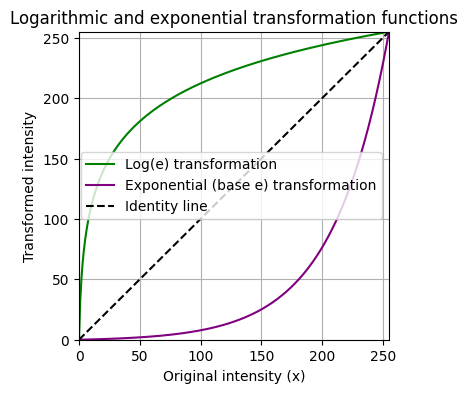

In [ ]:
# Maximum intensity value L for an 8-bit image
L = 256

# Create an array of intensity values from 0 to L-1
x = np.arange(0, L)

# Logarithmic transformation (normalize -> log transf. -> scale back
# Implements the function: log(1 + x) / log(256) * 255
loge_y = (np.log(1 + x) / np.log(L)) * (L - 1)

# Exponential transformation
# Implements the function: exp(x / 255 * log(256)) - 1
exp_e_y = np.exp(x / float(L - 1) * np.log(L)) - 1

# Plot the transformations
plt.figure(figsize=(4, 4))

# Logarithmic Transformation
plt.plot(x, loge_y, label="Log(e) transformation", color='green')

# Exponential Transformation
plt.plot(x, exp_e_y, label="Exponential (base e) transformation", color='purple')

# Identity line for reference
plt.plot(x, x, label="Identity line", color='black', linestyle='--')

# Labels and title
plt.xlabel('Original intensity (x)')
plt.ylabel('Transformed intensity')
plt.title('Logarithmic and exponential transformation functions')
plt.xlim(0, L-1)
plt.ylim(0, L-1)
plt.grid(True)
plt.legend()
plt.show()

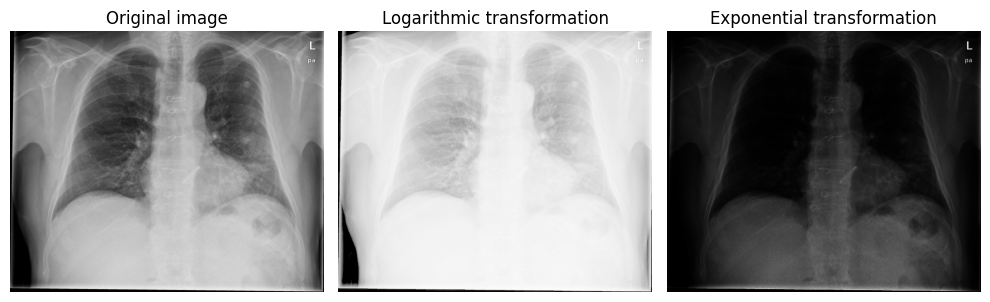

In [ ]:
# Load the image from a file in Google Drive
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Logarithmic and exponential transformations (with normalization and scaling back)

# np.log1p(x) computes log(1 + x) for numerically stability for small x values
log_image = np.uint8((np.log1p(image) / np.log(256)) * 255)
#log_image = np.uint8((np.log(1 + image) / np.log(256)) * 255)

# np.expm1(x) computes exp(x) - 1 for numerically stability for small values of x
exp_image = np.uint8(np.expm1(image / 255.0 * np.log(256)))
#exp_image = np.uint8(np.exp(image / 255.0 * np.log(256)) - 1)

# Plot the results
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Normalized image
plt.subplot(1, 3, 2)
plt.imshow(log_image, cmap='gray', vmin=0, vmax=255)
plt.title('Logarithmic transformation')
plt.axis('off')

# Corrected normalized image
plt.subplot(1, 3, 3)
plt.imshow(exp_image, cmap='gray', vmin=0, vmax=255)
plt.title('Exponential transformation')
plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 2.4.Sigmoid correction

This transform adjusts the intensity values of an image based on the **sigmoid function**, which maps the input intensities to output values in a **smooth, nonlinear way**.

This method can **enhance the contrast** of the image, especially **in the middle range of intensity values**.

The sigmoid function is defined as:

$$I_{\text{new}}(x, y) = T(x, y) = \frac{1}{1 + e^{-\alpha (I(x, y) - \beta)}}$$

where:

*	$I(x, y)$ is the original intensity of the pixel at position $(x, y)$,
*	$I_{\text{new}}(x, y)$ is the transformed intensity of the pixel,
*	$\alpha$ is a parameter that controls the slope of the sigmoid curve,
*	$\beta$ is a parameter that controls the midpoint of the sigmoid curve.

It **asymptotically approaches 0** for large negative values of $x$ **and 1** for large positive values of $x$.

After applying the sigmoid function, the resulting values are **normalized** to the desired intensity range (usually [0, 255] for 8-bit images).

The effect of this parameters in an image is that **$\alpha$ controls the contrast** ($\alpha\uparrow\, \Rightarrow$ the contrast increases), and **$\beta$ controls the brightness** ($\beta\downarrow\, \Rightarrow$ the brightness increases).


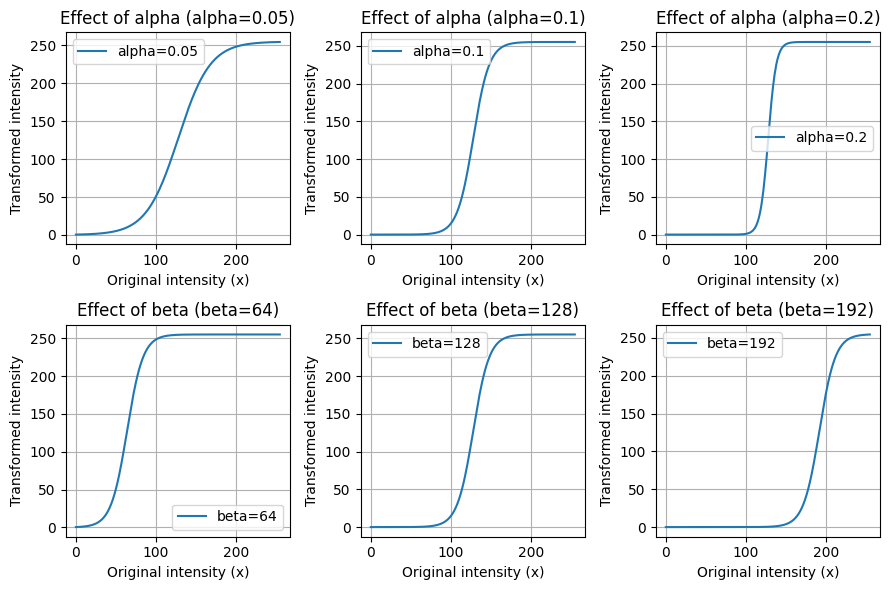

In [ ]:
# Define the range of intensity values (0 to 255 for an 8-bit image)
x = np.linspace(0, 255, 256)

# Sigmoid function parameters
alpha_values = [0.05, 0.1, 0.2]  # Varying alpha values
beta_values = [64, 128, 192]     # Varying beta values

# Create a figure
plt.figure(figsize=(9, 6))

# Plot the effect of changing alpha values
for i, alpha in enumerate(alpha_values):
    plt.subplot(2, 3, i + 1) # Subplots for the first row
    y = 1 / (1 + np.exp(-alpha * (x - 128)))  # beta is fixed at 128
    y_scaled = y * 255
    plt.plot(x, y_scaled, label=f'alpha={alpha}')
    plt.xlabel('Original intensity (x)')
    plt.ylabel('Transformed intensity')
    plt.title(f'Effect of alpha (alpha={alpha})')
    plt.grid(True)
    plt.legend()

# Plot the effect of changing beta values
for i, beta in enumerate(beta_values):
    plt.subplot(2, 3, i + 4)  # Subplots for the second row
    y = 1 / (1 + np.exp(-0.1 * (x - beta)))  # alpha is fixed at 0.1
    y_scaled = y * 255
    plt.plot(x, y_scaled, label=f'beta={beta}')
    plt.xlabel('Original intensity (x)')
    plt.ylabel('Transformed intensity')
    plt.title(f'Effect of beta (beta={beta})')
    plt.grid(True)
    plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

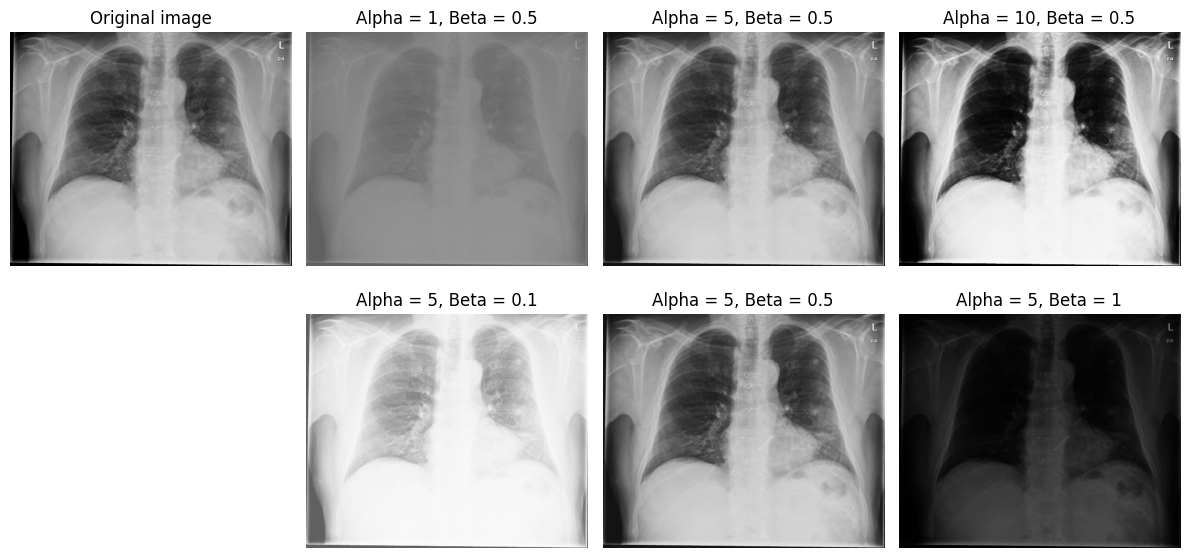

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Alpha and Beta values to test
alpha_values = [1, 5, 10]
beta_values = [0.1, 0.5, 1]

# Create a figure with 2 rows and 4 columns
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(2, 4, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Apply sigmoid correction with different alpha values
for i, alpha in enumerate(alpha_values):
    normalized_image = original_image / 255.0
    corrected_image = 1 / (1 + np.exp(-alpha * (normalized_image - 0.5)))  # beta=0.5
    corrected_image = (corrected_image * 255).astype(np.uint8)

    plt.subplot(2, 4, i + 2)
    plt.imshow(corrected_image, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Alpha = {alpha}, Beta = 0.5')
    plt.axis('off')

# Apply sigmoid correction with different beta values
for i, beta in enumerate(beta_values):
    normalized_image = original_image / 255.0
    corrected_image = 1 / (1 + np.exp(-5 * (normalized_image - beta)))  # alpha=5
    corrected_image = (corrected_image * 255).astype(np.uint8)

    plt.subplot(2, 4, i + 6)
    plt.imshow(corrected_image, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Alpha = 5, Beta = {beta}')
    plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 2.5. Piecewise Linear Transformation

A piecewise linear function for image transformation can be defined to **map specific ranges of pixel intensities to new values**, resulting in a transformation that can **enhance or suppress certain intensity ranges while maintaining a linear relationship** within those ranges.

It allows more **flexible and localized contrast adjustments**.

The piecewise linear function can be expressed as:

$$I_{\text{new}}(x, y) =
\begin{cases}
a_1 \cdot I(x, y) + b_1 & \text{if } I(x, y) \in [I_1, I_2) \\
a_2 \cdot I(x, y) + b_2 & \text{if } I(x, y) \in [I_2, I_3) \\
\vdots & \vdots \\
a_n \cdot I(x, y) + b_n & \text{if } I(x, y) \in [I_{n-1}, I_n] \\
I(x,y) & \text{otherwise}\\
\end{cases}$$

where:

*	$I(x, y)$ is the original intensity of the pixel at position $(x, y)$,
*	$I_{\text{new}}(x, y)$ is the transformed intensity of the pixel,
*	$[I_1, I_2), [I_2, I_3), \ldots, [I_{n-1}, I_n]$ are the specified ranges of intensity values,
*	$a_i$ and $b_i$ are the coefficients defining the linear transformation for the $i$-th intensity range.

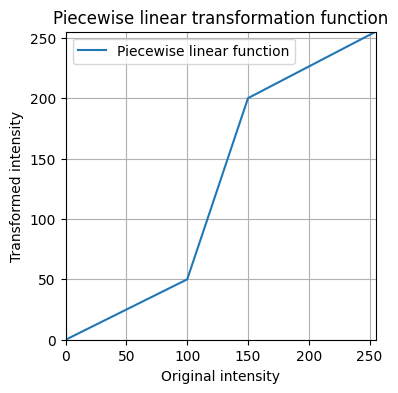

In [ ]:
# Create an array of gray levels
gray_levels = np.arange(256)

# Initialize an array with the same shape as 'gray_levels', filled with zeros, and of type float64
# It will be used to store the transformed intensity levels after applying the piecewise linear function
transformed_levels = np.zeros_like(gray_levels, dtype=np.float64)

# Apply the piecewise linear function to each gray level using a loop
for i, x in enumerate(gray_levels):
    if x < 100:
        transformed_levels[i] = 0.5 * x  # First segment
    elif x < 150:
        transformed_levels[i] = 3 * (x - 100) + 50  # Second segment
    else:
        transformed_levels[i] = (55 / 105) * (x - 150) + 200  # Third segment

# Plot the piecewise linear function
plt.figure(figsize=(4, 4))
plt.plot(gray_levels, transformed_levels, label='Piecewise linear function')
plt.xlabel('Original intensity')
plt.ylabel('Transformed intensity')
plt.title('Piecewise linear transformation function')
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.grid(True)
plt.legend()
plt.show()

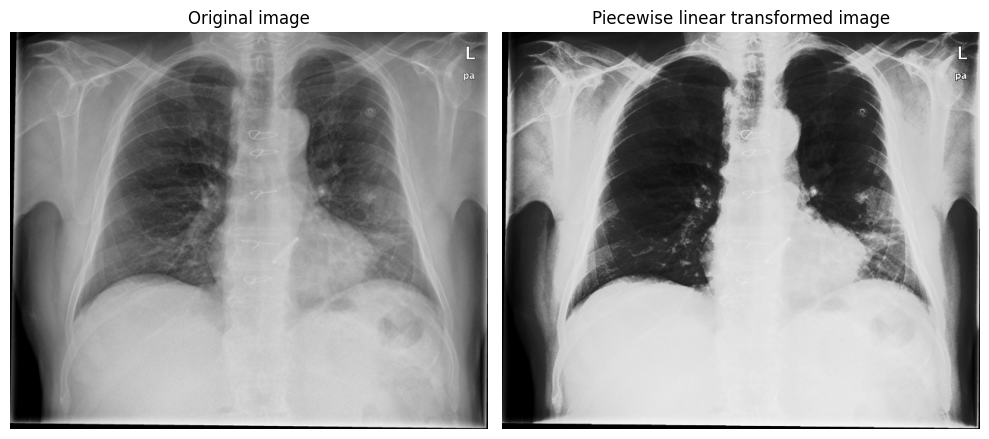

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Initialize the transformed image
transformed_image = np.zeros_like(image, dtype=np.uint8)

# Apply the piecewise linear transformation
for i in range(image.shape[0]): # rows
    for j in range(image.shape[1]): # columns
        value = image[i, j]
        if value < 100:
            transformed_image[i, j] = np.uint8(0.5 * value) # convert the new value to uint8 type
        elif value < 150:
            transformed_image[i, j] = np.uint8(3 * (value - 100) + 50)
        else:
            transformed_image[i, j] = np.uint8((55 / 105) * (value - 150) + 200)

# Display the original and transformed images using a simpler subplot format
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Transformed image
plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray', vmin=0, vmax=255)
plt.title('Piecewise linear transformed image')
plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### **Intensity level slicing**

Intensity level slicing refers to a **particular version** of piecewise linear transformation where a **specific range** of intensity values is **highlighted or mapped to a particular value**, while **all other values** are either **set to a different value** (often 0 or another background value) **or remain unaltered**.

Two types can be defined:

* **Binary (or hard) level slicing**:
	* Values within a specified range are set to a specific highlight value (e.g., 255 for white), whereas values outside this range are set to another value (e.g., 0 for black).
	* The result is a **binary image** where **only the specified range of intensities is highlighted**, and everything else is set to a uniform background.

* **Soft or gradual level slicing**:
	* Values within the **specified range** may be **enhanced or mapped to a specific range**, but not necessarily to a single value.
	* Values **outside the range** may remain **unaltered or** be **modified** in a more gradual form.



##### ***Hard level slicing***

It can be defined as:

$$
I_{\text{new}}(x, y) =
\begin{cases}
\text{high value} & \text{if } I(x, y) \in [I_{\text{low}}, I_{\text{high}}] \\
\text{low value} & \text{otherwise}
\end{cases}
$$

where:

* $I(x, y)$ is the original intensity value at pixel $(x, y)$,
* $I_{\text{low}}$ and $I_{\text{high}}$ define the range of interest,
* “high value” is the value assigned to the pixels within the range $[I_{\text{low}}, I_{\text{high}}]$,
*	“low value” is the value assigned to the pixels outside the range.

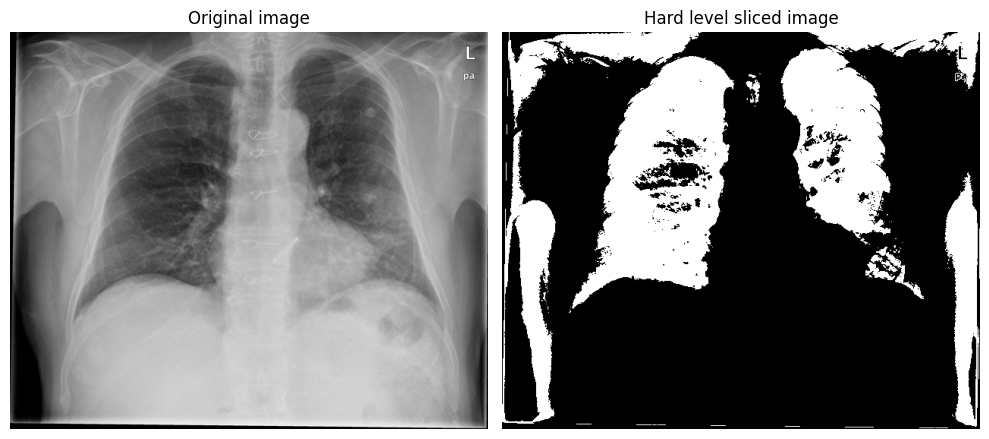

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define parameters for the piecewise linear transformation
I_low, I_high = 50, 120
highlight_value, background_value = 255, 0

# Initialize the transformed image
transformed_image = np.zeros_like(image, dtype=np.uint8)

# Apply the piecewise linear transformation
for i in range(image.shape[0]): # rows
    for j in range(image.shape[1]): # columns
        if I_low <= image[i, j] <= I_high:
            transformed_image[i, j] = highlight_value # highlight the range [I_low, I_high]
        else:
            transformed_image[i, j] = background_value # the rest is set to background_value

# Display the original and transformed images using a simpler subplot format
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.axis('off')

# Transformed image (Intensity Level Sliced)
plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray')
plt.title('Hard level sliced image')
plt.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

##### ***Soft level slicing***

The goal is to apply a transformation within the specified range $[I_{\text{low}}, I_{\text{high}}]$ but leave the values outside this range unaltered or slightly altered.

This transformation can be defined mathematically as follows:

$$
I_{\text{new}}(x, y) =
\begin{cases}
f(I(x, y)) & \text{if } I(x, y) \in [I_{\text{low}}, I_{\text{high}}] \\
g(I(x, y)) & \text{otherwise}
\end{cases}
$$

where:

* $I(x, y)$ is the original intensity value at pixel $(x, y)$,
* $f(I(x, y))$ is a function applied to the intensity values within the range $[I_{\text{low}}, I_{\text{high}}]$. This function can be a linear transformation, an enhancement, or any other transformation.
* $g(I(x, y))$ is a function applied to the intensity values outside the range $[I_{\text{low}}, I_{\text{high}}]$. In many cases, $g(I(x, y))$ might simply be $I(x, y)$ (i.e., leaving the values unaltered), but it could also involve some other transformation.



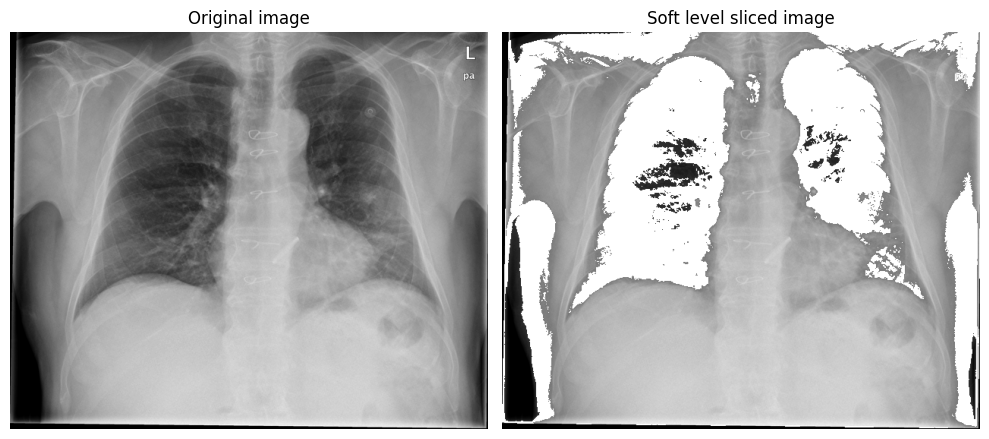

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Define parameters for the piecewise linear transformation
I_low, I_high = 50, 120
highlight_value = 255

# Initialize the transformed image
transformed_image = np.zeros_like(image, dtype=np.uint8)

# Apply the piecewise linear transformation
for i in range(image.shape[0]): # rows
    for j in range(image.shape[1]): # columns
        if I_low <= image[i, j] <= I_high:
            transformed_image[i, j] = highlight_value # highlight the range [I_low, I_high]
        else:
            transformed_image[i, j] = image[i, j] # the rest is unaltered

# Display the original and transformed images using a simpler subplot format
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Transformed image
plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray', vmin=0, vmax=255)
plt.title('Soft level sliced image')
plt.axis('off')

plt.tight_layout()
plt.show()

#### **Windowing**

**Windowing** is a pixel point technique used in medical imaging that **maps** the original intensity values stored in a DICOM file to grayscale values than can be displayed on a monitor.

This process involves selecting a **window level** (the midpoint of the Hounsfield Units (HU) value range of interest) and a **window width** (the range of HU values around the window level that will be displayed).

By adjusting the windowing parameters with standard HU values, radiologists can **better visualize specific structures of interest**, such as soft tissues, bones, or areas of calcification.





##### ***Hounsfield units in DICOM files***

**Windowing** can be considered a specific application of **intensity level slicing** to the medical field. In particular it is usually associated with **Hounsfield Units** in **CT images** to optimize the display for visual analysis.

In a DICOM file, the **Hounsfield Units for CT images** are **not stored directly as maximum and minimum values**.

Instead, the pixel values in the DICOM file are stored **as raw data**. The HU values can be calculated using specific DICOM tags.

The **DICOM tags** used to convert the raw pixel values to HU are:

* (0028,1053) _Rescale Slope_: it is a multiplicative factor used to convert the pixel values to HU.
* (0028,1052) _Rescale Intercept_: additive factor used to convert the pixel values to HU.

The formula to calculate Hounsfield Units from the raw pixel values is:

$$\text{HU} = (\text{Pixel Value} \times \text{Rescale Slope}) + \text{Rescale Intercept}$$

The DICOM tags _Rescale Slope_ and _Rescale Intercept_ might not always be present in non-CT images.

Raw min pixel value: 0.0
Raw max pixel value: 2226.0
Rescale Slope: 1.000244
Rescale Intercept: -1024.000000
Minimum HU value: -1024.0
Maximum HU value: 1202.5431439999998


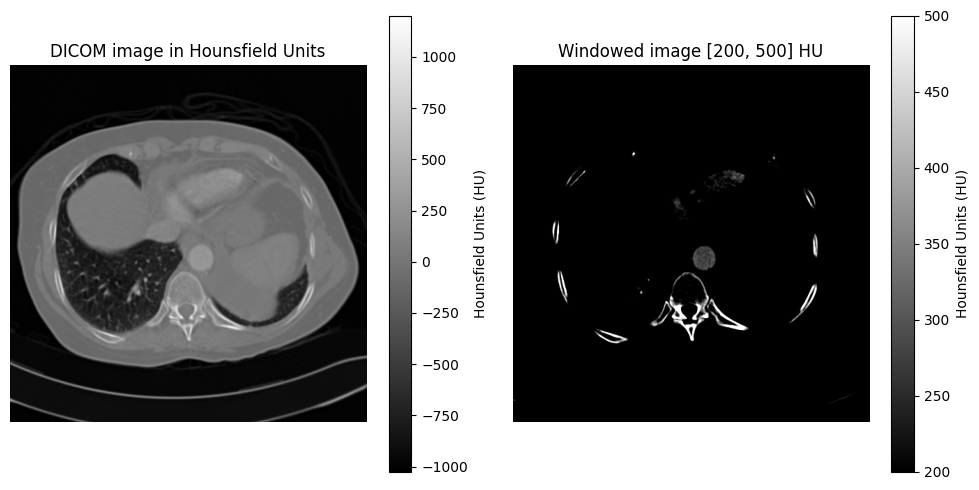

In [ ]:
# Function to convert pixel values to Hounsfield Units (HU)
def get_hounsfield_units(dicom_data):
    # Get the pixel array from the DICOM file (pixel_array)
    # DICOM files store pixel data as integers
    image = dicom_data.pixel_array.astype(np.float64) # Convert the pixel array to float64

    # Print the original min and max pixel values
    print("Raw min pixel value:", np.min(image))
    print("Raw max pixel value:", np.max(image))

    # Read the values of the DICOM tags 'RescaleSlope' and 'RescaleIntercept'

    # Get 'RescaleSlope', default to 1 if not found
    if 'RescaleSlope' in dicom_data:
      rescale_slope = dicom_data.RescaleSlope
    else:
      rescale_slope = 1

    # Get 'RescaleIntercept', default to 0 if not found
    if 'RescaleIntercept' in dicom_data:
      rescale_intercept = dicom_data.RescaleIntercept
    else:
      rescale_intercept = 0

    # Print the Rescale Slope and Rescale Intercept
    print("Rescale Slope:", rescale_slope)
    print("Rescale Intercept:", rescale_intercept)

    # Rescale the pixel values using the Rescale Slope and Rescale Intercept attributes
    # These attributes are used to convert the raw pixel values into Hounsfield Units (HU)
    # The conversion is done by applying the formula:
    # HU = RawPixelValue * RescaleSlope + RescaleIntercept
    hu_image = image * rescale_slope + rescale_intercept

    # Return the converted image in Hounsfield Units
    return hu_image

# Function to apply windowing
def apply_windowing(hu_image, HUmin, HUmax):
    # Create a copy of the image to apply windowing
    windowed_image = np.copy(hu_image)
    # windowed_image = hu_image will not work (both variables point to the same array in memory)
    # Any modifications made to windowed_image will also be reflected in hu_image (and vice versa)

    # Apply the windowing by setting values outside the range to HUmin
    # Create a boolean mask for pixel values in hu_image that are less (larger) than HUmin (HUmax)
    # Replace those pixel values in windowed_image with HUmin (HUmax)
    windowed_image[hu_image < HUmin] = HUmin
    windowed_image[hu_image > HUmax] = HUmax
    # The rest of values (HUmin <= hu_image <= HUmax) remain unaltered

    return windowed_image

# Read the DICOM file
dicom_file_path = '/content/drive/MyDrive/PIM/Images/ID_0032_CONTRAST_1_CT.dcm'
dicom_data = pydicom.dcmread(dicom_file_path)

# Convert the pixel values to Hounsfield Units
hu_image = get_hounsfield_units(dicom_data)

# Calculate and print the minimum and maximum HU values
min_HU = np.min(hu_image)
max_HU = np.max(hu_image)
print(f"Minimum HU value: {min_HU}")
print(f"Maximum HU value: {max_HU}")

# Define the HU range for windowing
window_HUmin, window_HUmax = 200, 500

# Apply windowing to the HU image
windowed_image = apply_windowing(hu_image, window_HUmin, window_HUmax)

# Create a 1x2 grid of subplots using plt.subplot
plt.figure(figsize=(10, 5))

# Display the original HU image
plt.subplot(1, 2, 1)
plt.imshow(hu_image, cmap='gray', vmin=min_HU, vmax=max_HU)
plt.title('DICOM image in Hounsfield Units')
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Hounsfield Units (HU)')

# Display the windowed HU image
plt.subplot(1, 2, 2)
plt.imshow(windowed_image, cmap='gray', vmin=window_HUmin, vmax=window_HUmax)
plt.title(f'Windowed image [{window_HUmin}, {window_HUmax}] HU')
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Hounsfield Units (HU)')

# Adjust layout
plt.tight_layout()
plt.show()

## 3.- Histogram-Based Techniques

The histogram of an image represents the **frequency or count of each pixel intensity** value within the image.

The **x-axis** represents **intensity values of pixels**, while the **y-axis** shows the **frequency or count** of pixels for each intensity value.

Usually, for a **8-bit grayscale image** with 256 intensity levels, the x axis is divided into **256 bins**, each representing one pixel intensity.

The **histogram** of an image is a **discrete function** that can be defined as $h(r_k) = n_k$, where $k = 0, 1, 2, \ldots, L-1$ represents the **index** of the intensity level, $r_k$ is the actual **intensity level** (or gray level) corresponding to $k$, and $n_k$ is the **frequency** of occurrence of this intensity level in the image.

The left side of the histogram represents lower pixel values (**darker**), while the right side of the histogram represents higher pixel values (**brighter**).



Intensity values:  [  0  36  72 109 145 182 218 255]


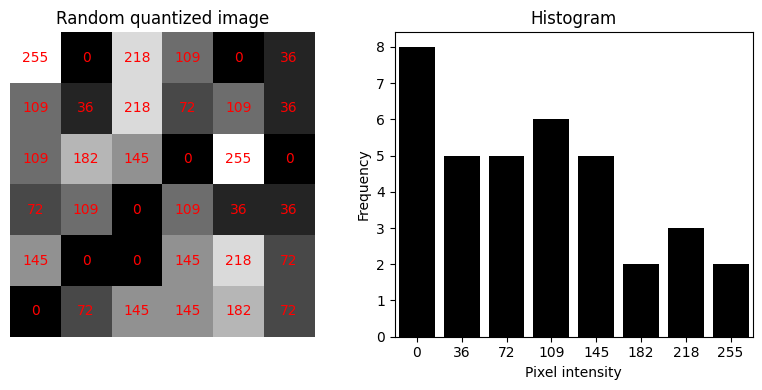

In [ ]:
# Define the number of levels
levels = 8

# Define the intensity values for quantization
intensity_values = np.linspace(0, 255, levels, dtype=int)
print("Intensity values: ", intensity_values)

# Generate a 6x6 array where each element is randomly chosen from the intensity_values
# np.random.choice selects random elements from intensity_values
# The shape (6, 6) indicates that the output will be a 6x6 matrix
image = np.random.choice(intensity_values, (6, 6))

# Calculate the histogram of the image.
# 'image.flatten()' converts the 2D image array into a 1D array
# This is necessary because np.histogram works on 1D arrays, not directly on 2D arrays
# 'bins=levels' specifies the number of bins (which corresponds to the intensity levels)
# 'range=[0, 256]' defines the range of intensity values to be considered (0-255 for 8-bit images)
hist_image, _ = np.histogram(image.flatten(), bins=levels, range=[0, 256])
# The resulting 'hist_image' contains the frequency of each intensity level in the image
# The second returned value (discarded with '_') contains the bin edges
# np.histogram computes the histogram but does not produce any plot (plt.hist does it)

# Create a figure with 1 row and 2 columns using plt.subplot
plt.figure(figsize=(8, 4))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('Random quantized image')
plt.axis('off')

# Annotate each pixel with its intensity value
for i in range(image.shape[0]): # rows
    for j in range(image.shape[1]): # columns
        plt.text(j, i, image[i, j], ha='center', va='center', color='red')

# Plot the histogram
plt.subplot(1, 2, 2)
plt.bar(range(levels), hist_image, color='black', width=0.8, align='center')
plt.title('Histogram')
plt.xlim([-0.5, levels - 0.5])  # Adjust x-axis limits to display full bars
plt.xticks(range(levels), intensity_values)
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The **shape** of the histogram can **reveal** useful **information about the image** and can be used for segmenting images.

However, two very different images may have the same histogram, as **the histogram does not account for the spatial relationship of pixel intensities with their neighbors**. This would require **texture analysis**, which considers the relationship between the intensity of a pixel and those of its neighbors.

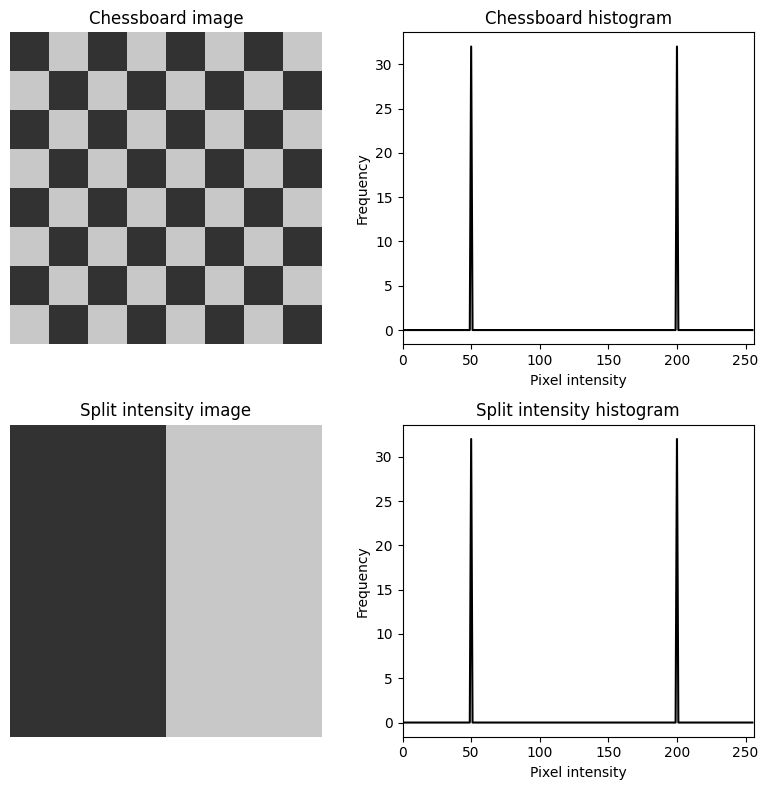

In [ ]:
# Create the chessboard image
chessboard = np.full((8, 8), 50, dtype=np.uint8)
chessboard[1::2, ::2] = 200 # slicing rows [1, 3, 5, 7] and columns [0, 2, 4, 6]
chessboard[::2, 1::2] = 200 # slicing rows [0, 2, 4, 6] and columns [1, 3, 5, 7]

# Create the half image
half_image = np.full((8, 8), 50, dtype=np.uint8)
half_image[:, 4:] = 200 # assign brighter intensity to the right half

# Compute histograms
hist_chessboard, _ = np.histogram(chessboard.flatten(), bins=256, range=[0, 256])
hist_half_image, _ = np.histogram(half_image.flatten(), bins=256, range=[0, 256])

# Create the figure and subplots
plt.figure(figsize=(8, 8))

# Chessboard image
plt.subplot(2, 2, 1)
plt.imshow(chessboard, cmap='gray', vmin=0, vmax=255)
plt.title('Chessboard image')
plt.axis('off')

# Chessboard histogram
plt.subplot(2, 2, 2)
plt.plot(hist_chessboard, color='black')
plt.title('Chessboard histogram')
plt.xlim([0, 256])
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Split Intensity Image
plt.subplot(2, 2, 3)
plt.imshow(half_image, cmap='gray', vmin=0, vmax=255)
plt.title('Split intensity image')
plt.axis('off')

# Split Intensity Histogram
plt.subplot(2, 2, 4)
plt.plot(hist_half_image, color='black')
plt.title('Split intensity histogram')
plt.xlim([0, 256])
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### 3.1. Thresholding

Thresholding is the most simple technique that **uses histogram information to process an image**. It converts a grayscale image into a **binary image** by **assigning** all pixels **above** a certain threshold value (a single or global threshold value for the entire image) **to one intensity** (usually 255 for white) and **all others to another intensity** (usually 0 for black).

The transformation is defined as:

$$I_{\text{new}}(x,y) =
\begin{cases}
255 & \text{if } I(x,y) \geq T \\
0 & \text{if } I(x,y) < T
\end{cases}$$

where $T$ is the threshold value.

The function `cv2.threshold()`in OpenCV computes the threshold of an image and returns the thresholded image, with the following parameters:

    retval, thresh_image = cv2.threshold(src, thresh, maxval, type)

* `src`: source image to which thresholding is applied,
* `thresh`: threshold value used for comparison,
* `maxval`: maximum value to assign to the pixels that meet the threshold condition,
* `type`: type of thresholding to be applied (`cv2.THRESH_BINARY`, `cv2.THRESH_OTSU`, ...),
* `retval`: threshold value used (useful for methods such as the Otsu's thresholding),
* `thresh_image`: output thresholded image.

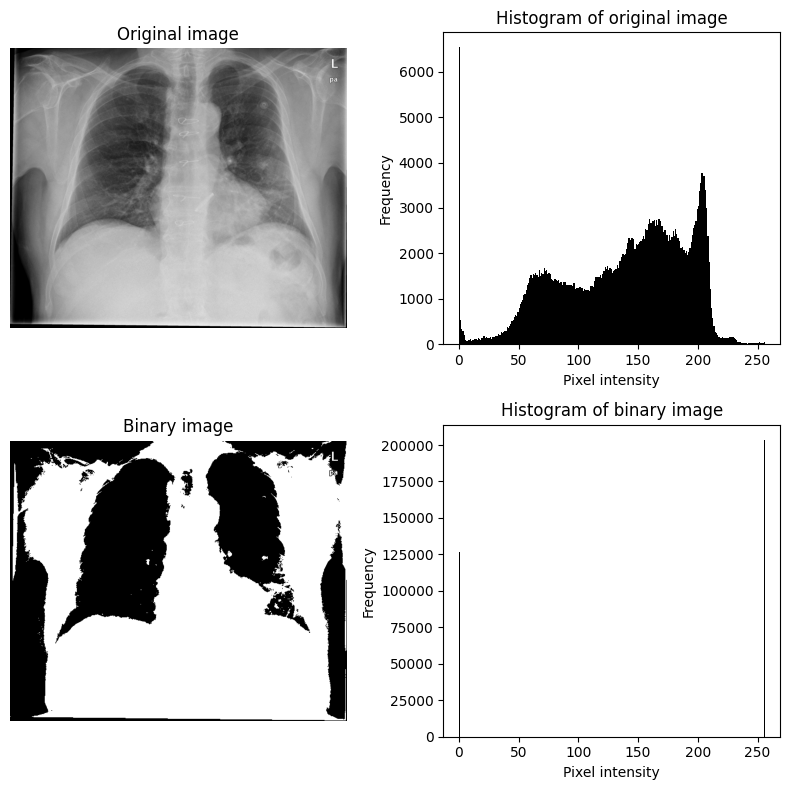

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Set a threshold value
threshold_value = 127

# Apply the threshold
# cv2.threshold is used to convert a grayscale image into a binary image
# Arguments:
# - original_image: input grayscale image
# - threshold_value: threshold value
# - 255: the maximum value assigned to pixels exceeding the threshold
# - cv2.THRESH_BINARY: the type of thresholding applied. THRESH_BINARY sets pixels above
#   the threshold to the max value, and pixels below the threshold to 0.
_, binary_image = cv2.threshold(original_image, threshold_value, 255, cv2.THRESH_BINARY)

# Create the figure
plt.figure(figsize=(8, 8))

# Plot the original image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Plot the histogram of the original image
plt.subplot(2, 2, 2)
plt.hist(original_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram of original image')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Plot the binarized image
plt.subplot(2, 2, 3)
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255)
plt.title('Binary image')
plt.axis('off')

# Plot the histogram of the binary image
plt.subplot(2, 2, 4)
plt.hist(binary_image.ravel(), bins=256, range=[0, 256], color='black')
plt.title('Histogram of binary image')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### 3.2. Adaptive Thresholding

Adaptive thresholding is a technique used to segment images that have **varying illumination conditions**.

Unlike global thresholding, which uses a single threshold value for the entire image, adaptive thresholding **calculates the threshold for smaller regions of the image**, allowing for more accurate segmentation of images with **uneven lighting**.

There are two types of adaptive thresholding:

**Mean Adaptive Thresholding**

The **threshold value** for a pixel is calculated as the **mean of the pixel values in the neighborhood area minus a constant C**:

$$T(x, y) = \frac{1}{N} \sum_{(i, j)\, \in\, \text{block}} I(i, j) - C$$

where:

* $\sum_{(i, j)\, \in\, \text{block}} I(i, j)$ is the sum of the pixel values in the block (neighborhood area) centered at $(x, y)$,
* $N$ is the number of pixels in the block,
* $C$ is a constant subtracted from the mean.

In OpenCV it is implemented with the function `cv2.adaptiveThreshold` with the parameter `cv2.ADAPTIVE_THRESH_MEAN_C`.

**Gaussian Adaptive Thresholding**

The **threshold value** for a pixel is calculated as the **weighted sum of the pixel values in the neighborhood area using a Gaussian window, minus a constant C**:

$$T(x, y) = \frac{1}{N} \sum_{(i, j)\, \in\, \text{block}} G(i, j) \cdot I(i, j) - C = \frac{1}{N} \sum_{(i, j)\, \in\, \text{block}} \frac{1}{2\pi\sigma^2} \exp\left(-\frac{i^2 + j^2}{2\sigma^2}\right) \cdot I(i, j) - C$$

where:

* $\sum_{(i, j) \in \text{block}} G(i, j) \cdot I(i, j)$ is the weighted sum of the pixel values in the block,
* $N$ is the normalization factor (sum of Gaussian weights),
* $C$ is a constant subtracted from the weighted sum,
* $G(i, j)$ is the Gaussian weight corresponding to the pixel at position $(i, j)$,
- $i$ and $j$ are the horizontal and vertical distances from the center of the neighborhood,
- $\sigma$ is the standard deviation of the Gaussian distribution.

It uses the same function (`cv2.adaptiveThreshold`) with the parameter `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`.






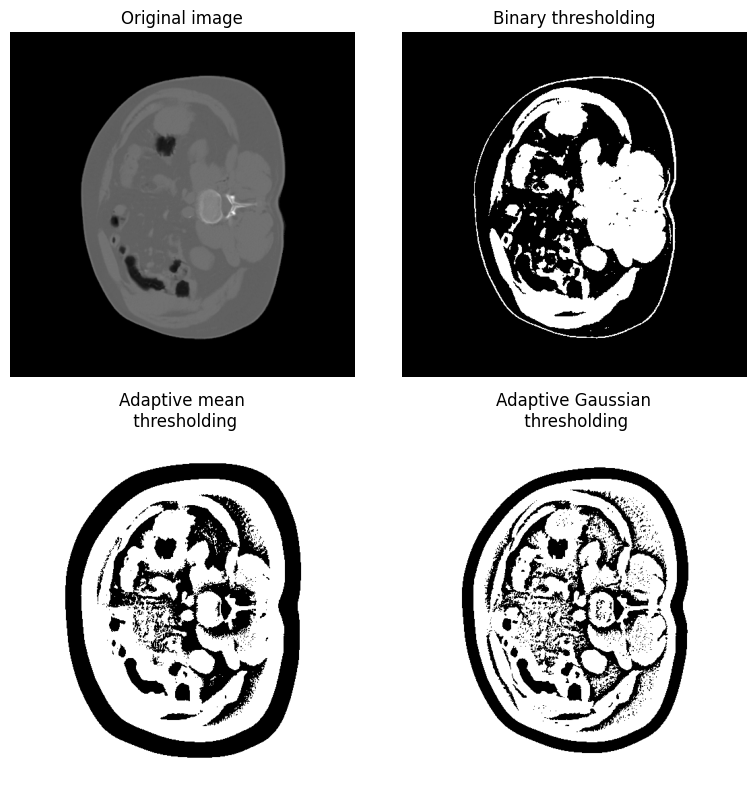

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/CT_slice_0016.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply the threshold
_, binary_image = cv2.threshold(original_image, 100, 255, cv2.THRESH_BINARY)

# Apply Adaptive Mean Thresholding
# Arguments:
# - original_image: input grayscale image
# - cv2.ADAPTIVE_THRESH_MEAN_C: the adaptive method calculates the threshold value as
#   the mean of the pixel values in the neighborhood area (specified by the block size), minus a constant C
# - cv2.THRESH_BINARY: the type of thresholding to apply (binary)
# - 49: block size (an odd number) that defines the size of the neighborhood around each pixel
#   to calculate the threshold
# - 2: the constant C that is subtracted from the mean value calculated for the neighborhood
adaptive_mean_image = cv2.adaptiveThreshold(
    original_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 49, 2)

# Apply Adaptive Gaussian Thresholding
# - cv2.ADAPTIVE_THRESH_GAUSSIAN_C: calculates the threshold value as a weighted sum of
#   the pixel values in the neighborhood area (with weights being determined by a Gaussian window),
#   minus a constant C.
adaptive_gaussian_image = cv2.adaptiveThreshold(
    original_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 49, 2)

# Create the figure
plt.figure(figsize=(8, 8))

# Plot the original image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Plot the binarized image
plt.subplot(2, 2, 2)
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255)
plt.title('Binary thresholding')
plt.axis('off')

# Plot the image with adaptive mean thresholding
plt.subplot(2, 2, 3)
plt.imshow(adaptive_mean_image, cmap='gray', vmin=0, vmax=255)
plt.title('Adaptive mean\n thresholding')
plt.axis('off')

# Plot the image with adaptive gaussian thresholding
plt.subplot(2, 2, 4)
plt.imshow(adaptive_gaussian_image, cmap='gray', vmin=0, vmax=255)
plt.title('Adaptive Gaussian\n thresholding')
plt.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

### 3.3. Contrast Stretching

Contrast stretching (or **normalization**) enhances the contrast of an image by **mapping linearly** the range of intensity values of the original image **to a new (wider) range**:

$$I_{\text{new}}(x, y) = \frac{I(x, y) - I_{\text{min}}}{I_{\text{max}} - I_{\text{min}}} \times (L_{\text{max}} - L_{\text{min}}) + L_{\text{min}}$$

where:

*	$I(x, y)$ is the original intensity of the pixel at position $(x, y)$,
* $I_{\text{new}}(x, y)$ is the transformed intensity of the pixel,
* $I_{\text{min}}$ and $I_{\text{max}}$ are the minimum and maximum intensity values in the original image, respectively,
* $L_{\text{min}}$ and $L_{\text{max}}$ are the desired minimum and maximum intensity values in the transformed image.

In the case of a 8-bit image, with intensities in the range [0, 255], the formula simplifies to:

$$I_{\text{new}}(x, y) = \frac{I(x, y) - I_{\text{min}}}{I_{\text{max}} - I_{\text{min}}} \times 255$$

OpenCV offers the function `cv2.normalize` for this purpose.

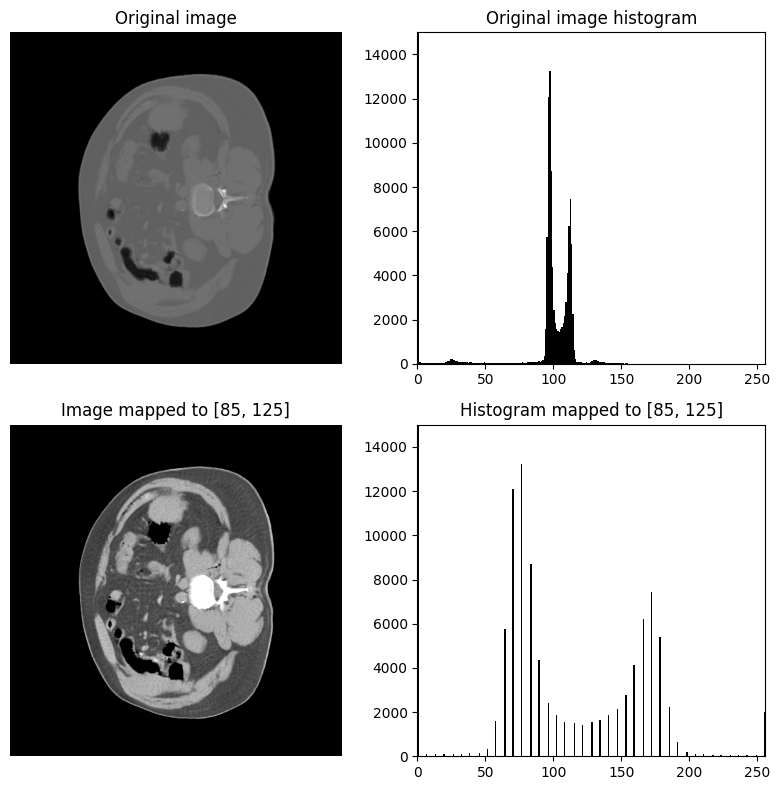

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/CT_slice_0016.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Minimum and maximum values that include most of the pixel intensities
lower_bound, upper_bound = 85, 125

# Clip values outside the range [lower_bound, upper_bound]
clipped_image = np.clip(original_image, lower_bound, upper_bound)

# Apply contrast stretching using OpenCV's normalize function
# 'original_image' is the input grayscale image
# 'None' indicates that the output image will be created automatically and will not return the result
# 'alpha=lower_bound' sets the lower bound of the new intensity range
# 'beta=upper_bound' sets the upper bound of the new intensity range
# 'norm_type=cv2.NORM_MINMAX' specifies that the normalization should map the
#    minimum and maximum intensity values in the original image to the range [alpha, beta]
mapped_image = cv2.normalize(clipped_image, None, 0, 255, norm_type=cv2.NORM_MINMAX)

# Create a 2x2 grid for plots using plt.subplot
plt.figure(figsize=(8, 8))

# Plot the original image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Plot the histogram of the original image
plt.subplot(2, 2, 2)
plt.hist(original_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Original image histogram')
plt.xlim([0, 256])
plt.ylim(0, 15000)

# Plot the mapped image
plt.subplot(2, 2, 3)
plt.imshow(mapped_image, cmap='gray', vmin=0, vmax=255)
plt.title(f'Image mapped to [{lower_bound}, {upper_bound}]')
plt.axis('off')

# Plot the histogram of the mapped image
plt.subplot(2, 2, 4)
plt.hist(mapped_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title(f'Histogram mapped to [{lower_bound}, {upper_bound}]')
plt.xlim([0, 256])
plt.ylim(0, 15000)

plt.tight_layout()
plt.show()

### 3.4. Histogram Equalization

In **low-contrast images**, the histogram is **narrow**, and does not extend from the left end to the right end.

**Histogram equalization improves the contrast** of an image **by uniformly redistributing the intensity values** of the image.

It aims to create a **uniform histogram** where **all intensity levels** are **equally probable** (flat histogram). This technique enhances the global contrast of the image, making features more visible.


The **algorithm** for computing the **normalized histogram** is the following:

1. Compute the probability or normalized count of each intensity level as:

  $$P(r_k) = \frac{n_k}{M\times N}$$
  
  where:

  * $P(r_k)$ is the probability or normalized count of occurrence of the gray level $r_k$,
  * $r_k$ is the gray level corresponding to the intensity level $k$,
  * $n_k$ is the number of pixels with gray level $k$,
  * $M\times N$ is the total number of pixels.

2. Calculate the cumulative probability calculation ($C(r_k)$) as:

  $$C(r_k) = \sum_{j=0}^{k} P(r_j)$$

3. Round the cumulative probability values, $C(r_k)$, to the nearest integers that represent intensity levels, $T(r_k)$:

  $$T(r_k) = \text{round}( (L-1) \times C(r_k) )$$

  where $L$ is the number of gray levels.

As an **example**, let's consider a 16x16-image with 8 gray levels. The first column of the table indicates the intensity level (0-7), and the second column represents the number of pixels of each intensity level.

In this case, the histogram has more pixels with low intensity values (biased towards the dark gray levels), so it represents a dark image.

| Gray Level | Number of Pixels | Probability | Cumulative Probability | New Gray Level |
|------------|------------------|-------------|------------------------|--------------|
| 0          | 65               | 0.2539      | 0.2539                 | 2 |
| 1          | 55               | 0.2148      | 0.4697                 | 3 |
| 2          | 45               | 0.1758      | 0.6465                 | 5 |
| 3          | 35               | 0.1367      | 0.7842                 | 5 |
| 4          | 25               | 0.0977      | 0.8828                 | 6 |
| 5          | 20               | 0.0781      | 0.9622                 | 7 |
| 6          | 11               | 0.0430      | 1.0000                 | 7 |
| 7          | 0                | 0.0000      | 1.0000                 | 7 |

The 3rd column (probability or normalized count of each intensity level) can be computed as

$$P(0)=\dfrac{65}{256}=0.2539$$
$$P(1)=\dfrac{55}{256}=0.2148$$
$$\ldots$$
$$P(6)=\dfrac{11}{256}=0.0430$$
$$P(7)=\dfrac{0}{256}=0$$

The cumulative probability function (4th column) is calculated as:

$$C(0)=0.2539$$
$$C(1)=0.2539+0.2148=0.4687$$
$$\ldots$$
$$C(6)=0.2539+0.2148+\ldots+0.0781+0.0430=1$$
$$C(7)=1$$

Finally, the **reassigned intensity levels after histogram equalization** are:

$$T(0)=\text{round}(7\times 0.2539)=\text{round}(1.78)=2$$
$$T(1)=\text{round}(7\times 0.4687)=\text{round}(3.28)=3$$
$$\ldots$$
$$T(6)=\text{round}(7\times 1)=7$$
$$T(7)=\text{round}(7\times 1)=7$$

So now, the number of pixels for each intensity in the equalized image is:

*	Intensity 0: 0 pixels (no intensity levels have been moved to new gray level 0)
*	Intensity 1: 0 pixels
*	Intensity 2: 65 pixels (number of pixels that originally had intensity 0, which have been moved to intensity 2)
*	Intensity 3: 55 pixels
*	Intensity 4: 0 pixels
*	Intensity 5: 45 + 35 = 80 pixels
*	Intensity 6: 25 pixels
*	Intensity 7: 20 + 11 + 0 = 31 pixels


Probability:  [0.25390625 0.21484375 0.17578125 0.13671875 0.09765625 0.078125
 0.04296875 0.        ]
Cumulative probability:  [0.25390625 0.46875    0.64453125 0.78125    0.87890625 0.95703125
 1.         1.        ]
New gray levels:  [2 3 5 5 6 7 7 7]
Original gray level 0 corresponds to gray level 2 (65 pixels)
Original gray level 1 corresponds to gray level 3 (55 pixels)
Original gray level 2 corresponds to gray level 5 (45 pixels)
Original gray level 3 corresponds to gray level 5 (80 pixels)
Original gray level 4 corresponds to gray level 6 (25 pixels)
Original gray level 5 corresponds to gray level 7 (20 pixels)
Original gray level 6 corresponds to gray level 7 (31 pixels)
Original gray level 7 corresponds to gray level 7 (31 pixels)


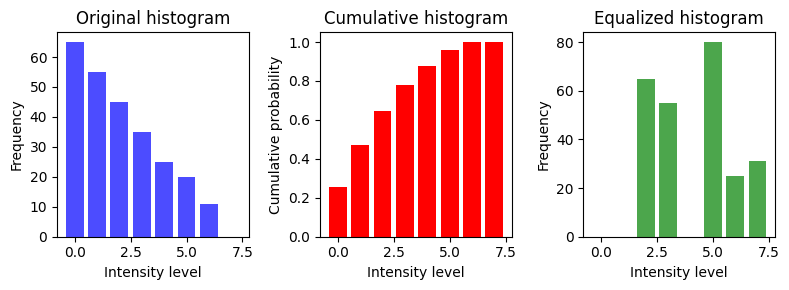

In [ ]:
# Define the original histogram values (biased towards dark levels)
histogram = np.array([65, 55, 45, 35, 25, 20, 11, 0])

# Number of pixels in the image
total_pixels = 16 * 16

# Calculate the probabilities
probabilities = histogram / total_pixels
print("Probability: ", probabilities)

# Calculate the cumulative distribution function (CDF)
cdf = np.cumsum(probabilities)
print("Cumulative probability: ", cdf)

# Apply histogram equalization
equalized_values = np.round(cdf * (len(histogram) - 1)).astype(int)
print("New gray levels: ", equalized_values)

# Initialize an empty histogram with the same size as the original histogram
new_histogram = np.zeros_like(histogram)

# Loop through each intensity level in the original histogram
for original_value in range(len(histogram)):

    # Get the corresponding new intensity level after equalization
    new_value = equalized_values[original_value]

    # Move the pixel count from the original intensity level to the new one
    # This means adding the count of pixels from the original level to the new level
    new_histogram[new_value] += histogram[original_value]

    # Print gray level correspondence (original and new) and the number of pixels assigned
    print(f"Original gray level {original_value} corresponds to gray level " \
          f"{equalized_values[original_value]} ({new_histogram[new_value]} pixels)")

# Display the results using plt.subplot()
plt.figure(figsize=(8, 3))

# Original histogram
plt.subplot(1, 3, 1)
plt.bar(range(len(histogram)), histogram, color='blue', alpha=0.7)
plt.title('Original histogram')
plt.xlabel('Intensity level')
plt.ylabel('Frequency')

# Cumulative histogram
plt.subplot(1, 3, 2)
plt.bar(range(len(cdf)), cdf, color='red')
plt.title('Cumulative histogram')
plt.xlabel('Intensity level')
plt.ylabel('Cumulative probability')

# Equalized histogram
plt.subplot(1, 3, 3)
plt.bar(range(len(new_histogram)), new_histogram, color='green', alpha=0.7)
plt.title('Equalized histogram')
plt.xlabel('Intensity level')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

OpenCV uses the function `cv2.equalizeHist(image)` and returns the equalized image.

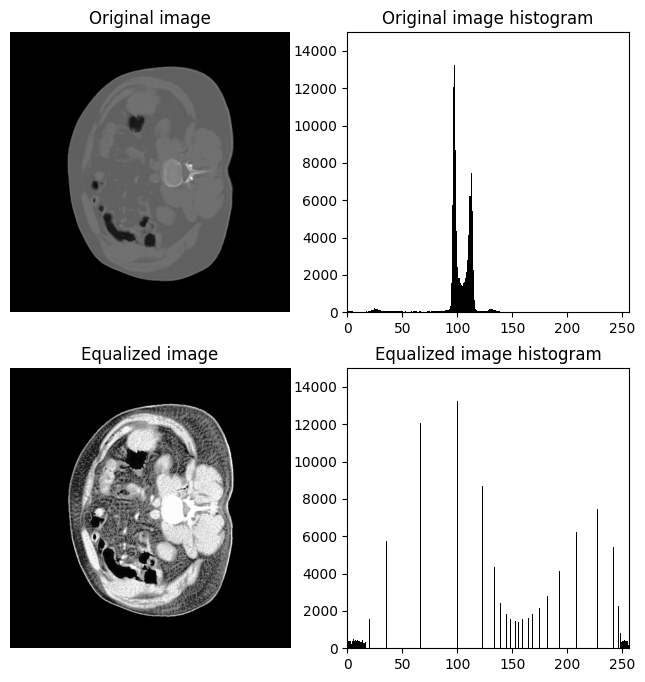

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/CT_slice_0016.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply histogram equalization
equalized_image = cv2.equalizeHist(original_image)

# Create a 1x2 subplot to compare original and equalized images
plt.figure(figsize=(8, 8))

# Display the original image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Plot the histogram of the original image (it uses plt.hist)
plt.subplot(2, 2, 2)
# Plot the histogram of the original image
# Flatten the 2D image array into a 1D array of pixel intensities using .flatten()
# This allows us to pass the pixel intensities as a 1D array to the histogram function
plt.hist(                      # Plot the histogram
    original_image.flatten(),  # Flatten the 2D image to 1D
    bins=256,                  # Create 256 bins, one for each possible intensity value (0-255)
    range=[0, 256],            # Set the range of the histogram from 0 to 255 (inclusive)
    color='black'              # Set the color of the histogram bars to black
)
plt.title('Original image histogram')
plt.xlim([0, 256])
plt.ylim(0, 15000)

# Display the equalized image
plt.subplot(2, 2, 3)
plt.imshow(equalized_image, cmap='gray', vmin=0, vmax=255)
plt.title('Equalized image')
plt.axis('off')

# Plot the histogram of the equalized image
plt.subplot(2, 2, 4)
plt.hist(equalized_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Equalized image histogram')
plt.xlim([0, 256])
plt.ylim(0, 15000)

plt.show()

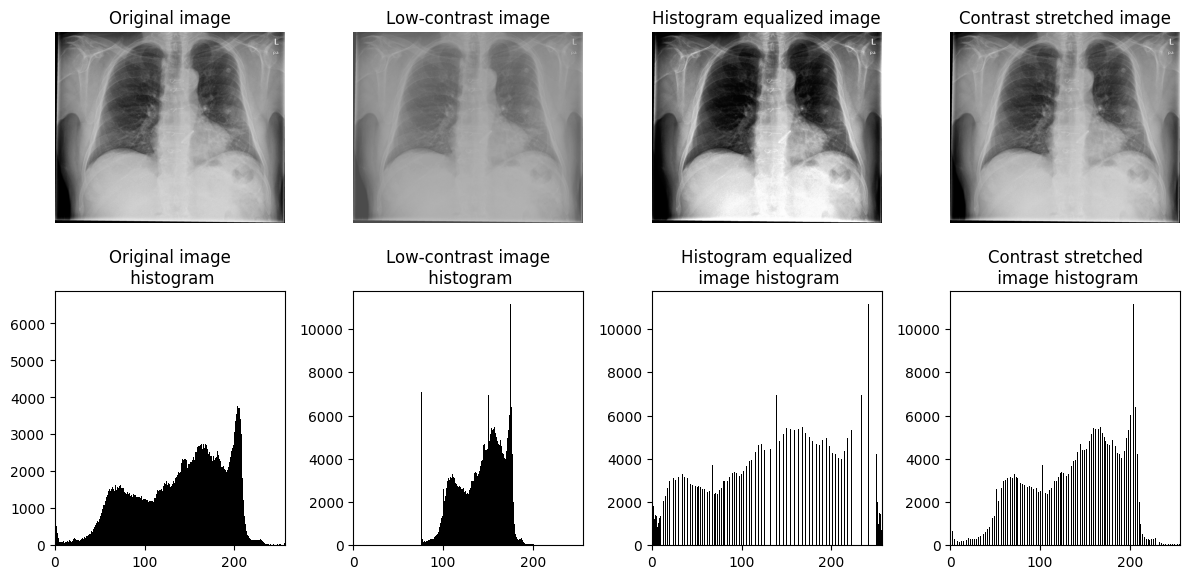

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Simulates a low contrast image derived from the original image
low_contrast_image = cv2.normalize(original_image, None, alpha=75, beta=200, norm_type=cv2.NORM_MINMAX)

# Apply histogram equalization to the low-contrast image
equalized_image = cv2.equalizeHist(low_contrast_image)

# Apply contrast stretching to the low-contrast image (stretched to the full 0-255 range)
stretched_image = cv2.normalize(low_contrast_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Display the original, mapped, equalized, and stretched images
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(2, 4, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Plot the low-contrast image
plt.subplot(2, 4, 2)
plt.imshow(low_contrast_image, cmap='gray', vmin=0, vmax=255)
plt.title('Low-contrast image')
plt.axis('off')

# Plot the histogram-equalized image
plt.subplot(2, 4, 3)
plt.imshow(equalized_image, cmap='gray', vmin=0, vmax=255)
plt.title('Histogram equalized image')
plt.axis('off')

# Plot the contrast-stretched image
plt.subplot(2, 4, 4)
plt.imshow(stretched_image, cmap='gray', vmin=0, vmax=255)
plt.title('Contrast stretched image')
plt.axis('off')

# Plot the histogram of the original image
plt.subplot(2, 4, 5)
plt.hist(original_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Original image\n histogram')
plt.xlim([0, 256])

# Plot the histogram of the low-contrast image
plt.subplot(2, 4, 6)
plt.hist(low_contrast_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Low-contrast image\n histogram')
plt.xlim([0, 256])

# Plot the histogram of the histogram-equalized image
plt.subplot(2, 4, 7)
plt.hist(equalized_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Histogram equalized\n image histogram')
plt.xlim([0, 256])

# Plot the histogram of the contrast-stretched image
plt.subplot(2, 4, 8)
plt.hist(stretched_image.flatten(), bins=256, range=[0, 256], color='black')
plt.title('Contrast stretched\n image histogram')
plt.xlim([0, 256])

# Adjust layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()

### 3.5. Contrast Limited Adaptive Histogram Equalization (CLAHE)

This technique is an **advanced version of histogram equalization to improve the contrast** of an image.

It differs from standard histogram equalization in that it works on **small regions** in the image, called tiles, rather than the entire image, and **a histogram of each tile is computed**.

It is specially useful in **images with uneven lightning**.

The **algorithm** follows this **steps**:

1. **Divide the image** into non-overlapping tiles.
2. Calculate the **histogram of each tile** independently.
3. Apply **histogram equalization for each tile**, to  increase the contrast of the tiles.
4. **Clip the histograms** by setting a threshold or maximum value to limit the amplification of noise.
5. **Redistribute the clipped pixels** (those pixels that exceed the clip limit) equally among all histogram bins, **preserving** the overall image **brightness**.
6. Apply **bilinear interpolation** to the intensity values and **combine the tiles** to form the final image.

The implementation in OpenCV requires two related functions:

* `clahe = cv2.createCLAHE(clipLimit, tileGridSize)`:

  This function creates a CLAHE object, which is used to apply the CLAHE algorithm to an image.

  Parameters:

  * `clipLimit`: limits the contrast enhancement to avoid over-amplifying noise in uniform areas. Lower values have the effect of less contrast enhancement. Higher values achieve more contrast enhancement bue can also amplify noise.

  * `tileGridSize`: size of the grid for dividing the image into smaller regions (tiles). It's a tuple $(x, y)$ that defines the size of the grid for the histogram equalization.

  * `clahe`: object that can be used to apply the CLAHE algorithm to an image.


* `clahe_image = clahe.apply(image)`:

	This method applies the CLAHE algorithm to the input image.

  Parameters:

  * `image`: input image, which should be a single-channel grayscale image,
  
  * `clahe_image`: contrast-enhanced image after applying CLAHE.

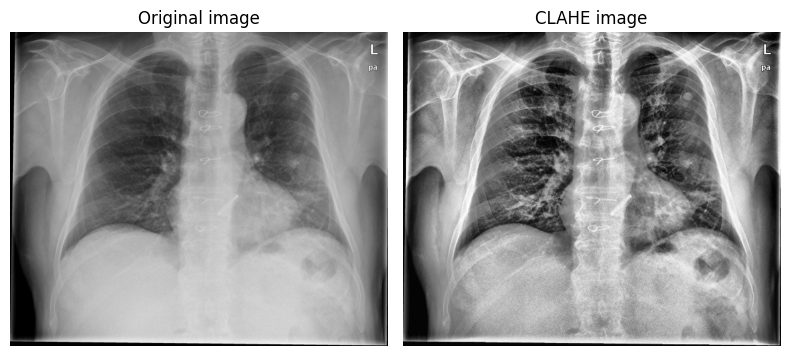

In [ ]:
# Load the original image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))

# Apply CLAHE to the original image
clahe_image = clahe.apply(original_image)

plt.figure(figsize=(8, 8))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.axis('off')

# Plot the CLAHE-enhanced image
plt.subplot(1, 2, 2)
plt.imshow(clahe_image, cmap='gray', vmin=0, vmax=255)
plt.title('CLAHE image')
plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

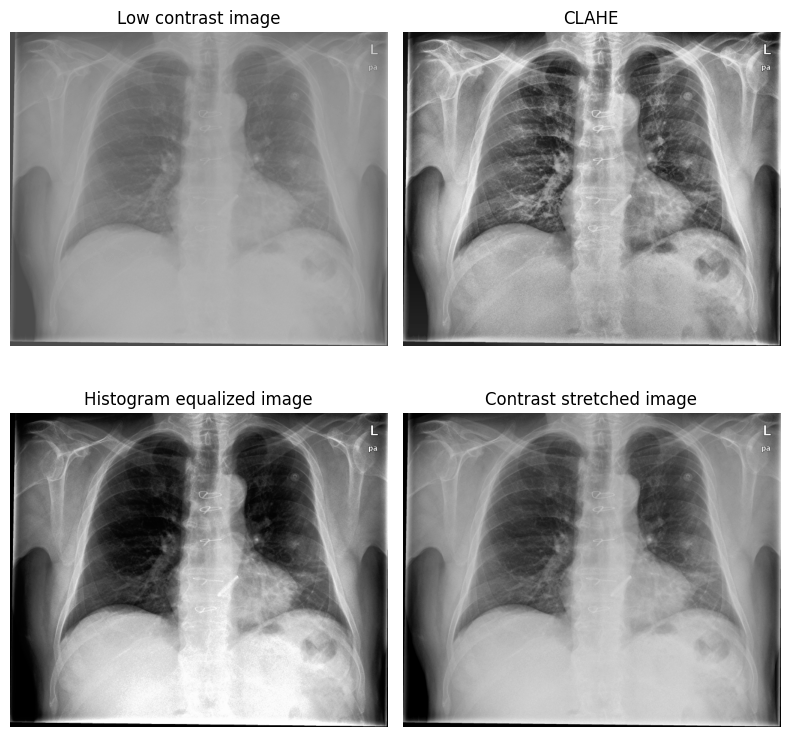

In [ ]:
# Compares CLAHE, histogram equalization and contrast stretching applied to the low contrast image

# Create a CLAHE object (Arguments are optional)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))

# Apply CLAHE to the original image
clahe_image = clahe.apply(low_contrast_image)

# Define the images and titles
images = [low_contrast_image, clahe_image, equalized_image, stretched_image]
titles = ['Low contrast image', 'CLAHE', 'Histogram equalized image', 'Contrast stretched image']

# Plot all images using plt.subplot
plt.figure(figsize=(8, 8))

# Loop through the images and titles to display each one
for i in range(len(images)):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of subplots
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Applying CLAHE algorithm **recursively** multiple times may **enhance the image** even further, leading to a **higher contrast** image. It has the effect of **flattening** the histogram.

However, this could also lead to **over-enhancement**, where the image starts to look unnatural, introducing **artifacts** and amplifying **noise** in each iteration.

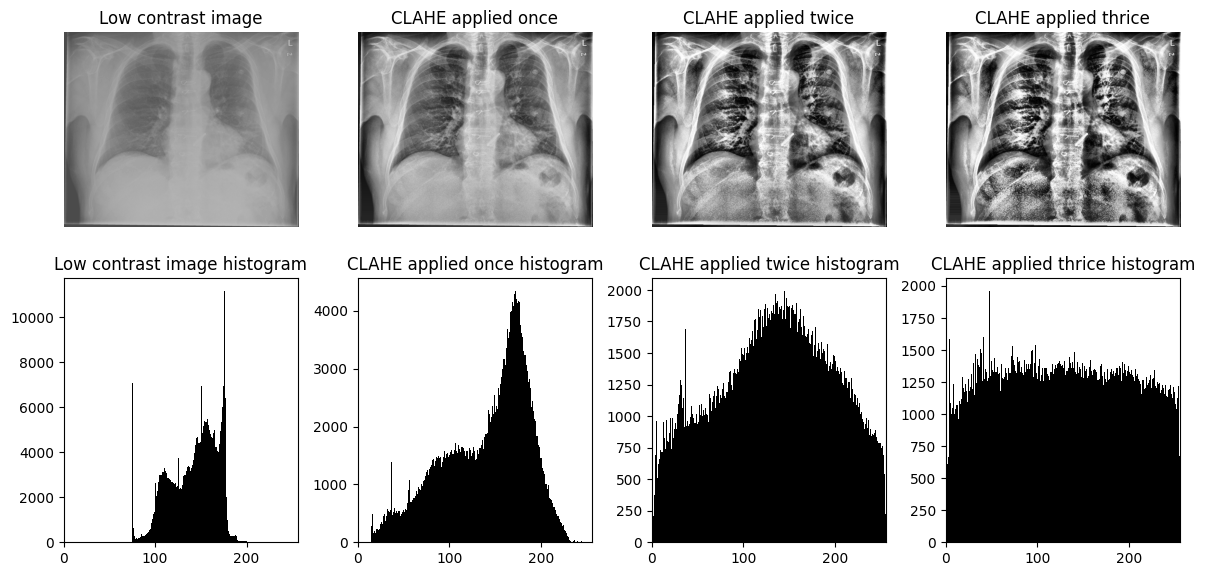

In [ ]:
# Recursive CLAHE

# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))

# Apply CLAHE up to three times
clahe_image_1 = clahe.apply(low_contrast_image)
clahe_image_2 = clahe.apply(clahe_image_1)
clahe_image_3 = clahe.apply(clahe_image_2)

# List of images and titles
images = [low_contrast_image, clahe_image_1, clahe_image_2, clahe_image_3]
titles = ['Low contrast image', 'CLAHE applied once', 'CLAHE applied twice', 'CLAHE applied thrice']

# Display the images in a 1x4 grid (first row)
plt.figure(figsize=(12, 6))

for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.axis('off')

# Display the corresponding histograms in a 1x4 grid (second row)
for i in range(4):
    plt.subplot(2, 4, i + 5)
    plt.hist(images[i].flatten(), bins=256, range=[0, 256], color='black')
    plt.title(f'{titles[i]} histogram')
    plt.xlim([0, 256])

plt.tight_layout()
plt.show()

## 4.- Bit-Plane Slicing

Bit-plane slicing involves **decomposing an image into its binary components**, or **bit planes**.

Each **pixel** in a grayscale image can be **represented** by an **8-bit binary number**. By **separating these bits into different planes**, each bit plane represents a binary image highlighting the presence of the corresponding bit in the original pixel values.

This decomposition helps analyze the **relative importance of each bit** to the overall image, which may aid to **determine whether the number of bits used for quantization is adequate**.

The two end bit-planes are:

*	**Bit-plane 0**: contains the least significant bit (LSB) of each pixel. This plane has the **least influence** on the overall image intensity and is often **noise**.
*	**Bit-plane 7**: contains the most significant bit (MSB) of each pixel. This plane has the **most influence** on the overall image intensity and **captures the most significant features**.

**For example**, for a pixel with intensity 150 (binary 10010110), the values for that pixel in the 8 bit-planes would be:

*	Bit-plane 0: 0
*	Bit-plane 1: 1
*	Bit-plane 2: 1
*	Bit-plane 3: 0
*	Bit-plane 4: 1
*	Bit-plane 5: 0
*	Bit-plane 6: 0
*	Bit-plane 7: 1

Its **applications** in medical imaging includes:

* **Highlighting details**: by **isolating** certain bit planes, specific details or features can be **highlighted**.
*	**Compression**: bit-plane slicing can be used as a very basic image compression technique by **focusing on the most significant bit planes**.
*	**Noise reduction**: by manipulating or **ignoring** certain bit planes (usually the least significant ones), noise can be reduced.

Bit-plane slicing can be considered somewhat analogous to **wavelet decomposition**, but instead of analyzing different scales or frequencies, it focuses on the binary representation of image intensities.

It can be very effective for **simpler tasks** and can be useful in specific scenarios, particularly in binary or near-binary images. However, wavelet transforms are more powerful and complex, and more suitable when multiresolution analysis is required.


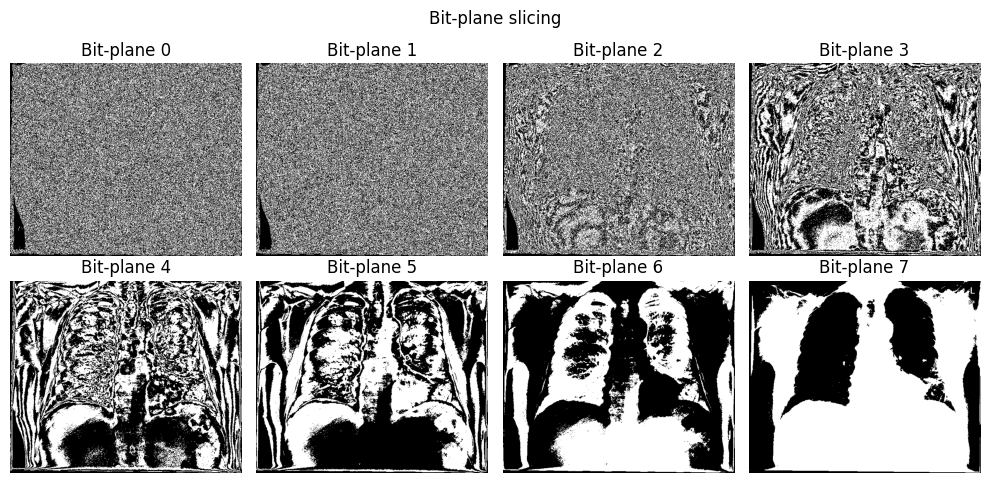

In [ ]:
# Load the image in grayscale
image_path = '/content/drive/MyDrive/PIM/Images/X-ray_1.jpeg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Extract and display the 8 bit-planes
plt.figure(figsize=(10, 5))
plt.suptitle('Bit-plane slicing')

for i in range(8):
    # Extract the specific bit-plane
    bit_plane_image = (original_image >> i) & 1  # Shift to extract the i-th bit and mask to get that bit
    # After 8 iterations, all 8 bit planes (from the 0th bit to the 7th bit) have been extracted
    bit_plane_image *= 255  # Scale to full intensity range

    # Display the bit-plane image in the appropriate subplot
    plt.subplot(2, 4, i + 1)
    plt.imshow(bit_plane_image, cmap='gray')
    plt.title(f'Bit-plane {i}')
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

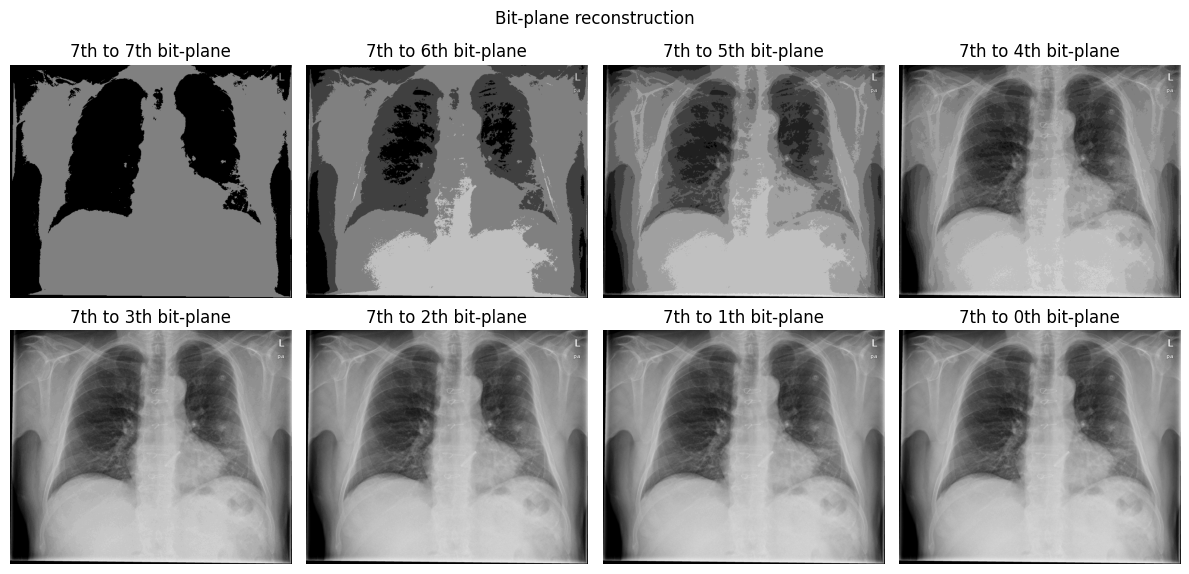

In [ ]:
# Prepare the figure for plotting
plt.figure(figsize=(12, 6))
plt.suptitle('Bit-plane reconstruction')

# Initialize an empty image to accumulate the bit-planes
accumulated_image = np.zeros_like(original_image, dtype=np.uint8)

# Loop through from the 7th bit-plane (MSB) down to the 0th bit-plane (LSB)
for i in range(7, -1, -1): # values from 7 to 0
    # Extract the specific bit-plane and add it to the accumulated image
    bit_plane_image = (original_image >> i) & 1  # Extract the i-th bit
    accumulated_image += bit_plane_image << i    # Add the bit-plane back to
                                                 # its original place in the image

    # Display the accumulated image after adding each bit-plane
    plt.subplot(2, 4, 8 - i)
    plt.imshow(accumulated_image, cmap='gray', vmin=0, vmax=255)
    plt.title(f'7th to {i}th bit-plane')
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## References

* González, Rafael C., _Digital image processing: Chapter 3 (Intensity Transformations and Spatial Filtering)_. Prentice Hall,. 2018. 9780132345637

* Chityala, Ravishankar, _Image Processing and Acquisition Using Python: Chapter 5 (Image Enhancement)_. Chapman and Hall/CRC, 2022. 9780367531577

* Birkfellner, Wolfgang, _Applied Medical Image Processing - A Basic Course: Chapter 4 (Operations in Intensity Space)_. CRC Press, 2014. 9781466555570

* Fernández Villán, Alberto, _Mastering OpenCV 4 with Python: Chapter 6 (Constructing and Building Histograms)_. Packt. 2019. 9781789344912

